In [9]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [10]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cpu'

In [11]:
def prepare_data(name_file):
    global X_train, X_test, X_val, y_train, y_test, y_val, scaler
    data = pd.read_csv(name_file)
    print(data.info())
    data = data[['Daily_Usage_Hours', 'Sleep_Hours', 'Academic_Performance']]
    X = data.iloc[:,0:2].values
    print (X)
    y = data.Academic_Performance.values
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [12]:
prepare_data('teen_phone_addiction_dataset.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      100 non-null    int64  
 1   Name                    100 non-null    object 
 2   Age                     100 non-null    int64  
 3   Gender                  100 non-null    object 
 4   Location                100 non-null    object 
 5   School_Grade            100 non-null    object 
 6   Daily_Usage_Hours       100 non-null    float64
 7   Sleep_Hours             100 non-null    float64
 8   Academic_Performance    100 non-null    int64  
 9   Social_Interactions     100 non-null    int64  
 10  Exercise_Hours          100 non-null    float64
 11  Anxiety_Level           100 non-null    int64  
 12  Depression_Level        100 non-null    int64  
 13  Self_Esteem             100 non-null    int64  
 14  Parental_Control        100 non-null    int

In [ ]:
class ClassificationNM(nn.Module):
    def __init__ (self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        
    def mytrain(self, X_train, y_train, X_val, y_val, loss_fn, optimizer):
        torch.manual_seed(0)
        torch.cuda.manual_seed(0)
        epochs = 3000
        X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
        y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
        X_val = torch.tensor(X_val, dtype=torch.float32, device=device)
        y_val = torch.tensor(y_val, dtype=torch.float32, device=device)
        
        for epoch in range(epochs):
            #Training
            self.train()
            
            #Forward pass
            y_logist = self(X_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logist))
            
            #Calculate loss and accuracy
            loss = loss_fn(y_logist, y_train)
            
            #Optimizer zero grad
            optimizer.zero_grad()
            
            #Loss backward
            loss.backward()
            
            #Optimizer step
            optimizer.step()
            
            #Testing
            self.eval()
            with torch.inference_mode():
                #Forward pass
                val_logists = self(X_val).squeeze()
                val_preds = torch.round(torch.sigmoid(val_logists))
                
                #Calculate loss
                test_loss = loss_fn(val_logists, y_val)
                
                
                if epoch % 100 == 0:
                    y_true_train = y_train.to('cpu').numpy()
                    y_pred_train = y_pred.detach().to('cpu').numpy()
                    y_true_val = y_val.to('cpu').numpy()
                    y_pred_val = val_preds.detach().to('cpu').numpy()
                    
                    acc = accuracy_score(y_true = y_true_train, y_pred = y_pred_train)
                    
                    test_acc = accuracy_score(y_true = y_true_val, y_pred = y_pred_val)
                    
                    print(f"Epoch: {epoch + 100} | Loss: {loss:.5f} | Train Acc: {acc:.5f} | Val loss: {test_loss:.5f} | Val Acc: {test_acc:.5f}")
                
                

In [18]:
ClassificationNM1 = ClassificationNM().to(device)
ClassificationNM1

ClassificationNM(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params= ClassificationNM1.parameters(), lr=0.1)


In [20]:
ClassificationNM1.mytrain(X_train, y_train, X_val, y_val, loss_fn, optimizer)

c:\Users\luism\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\luism\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\luism\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\externals\array_api_compat\numpy\_aliases.py:127: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype=dtype, copy=copy)


Epoch: 100 | Loss: 38.31890 | Train Acc: 0.00000 | Val loss: -977.00354 | Val Acc: 0.00000


ValueError: Input y_pred contains NaN.

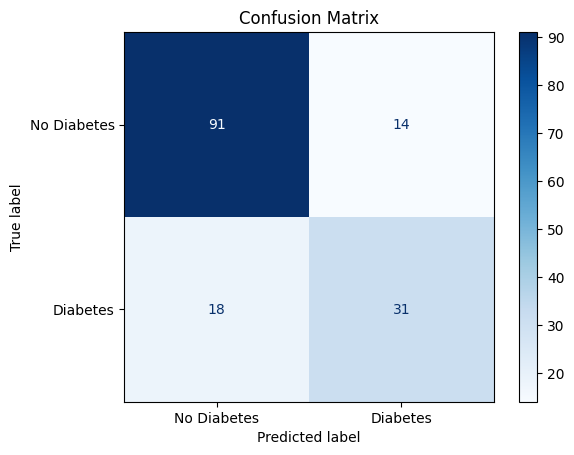

In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
test_logists = ClassificationNM1(X_test).squeeze()
test_pred = torch.round(torch.sigmoid(test_logists))
y_pred_test = test_pred.detach().to('cpu').numpy()
conf_mat = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.69      0.63      0.66        49

    accuracy                           0.79       154
   macro avg       0.76      0.75      0.76       154
weighted avg       0.79      0.79      0.79       154

